## Set things up

In [1]:
%matplotlib inline
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
RAW_DATA_SOURCE = "C:/Users/sbranchett/Data/WiFi_data/WiFiAccessPoint_4weeks.csv"
CLEAN_DATA_SOURCE = "CleanedWiFiAccessPoint_4weeks.csv"

## Read in data

In [3]:
def load_wifi_data(path):
    """
    Read WiFi clientCount .csv file and sum the clientCounts over building and timestamp, bucketed to 5 minutes
    
    Input: filepath the .csv file
    Output: Dataframe with "building", "time_bucket", "clientCount"
    Columns "building" generated from "locationHierarchy", and "time_bucket" generated from "timestamp"
    """
    all_data = pd.read_csv(path, delimiter=",")
    all_data = all_data.rename(columns=lambda x: x.strip())  # get rid of extra spaces in column names

    sum_clientCounts = all_data["clientCount"].sum()
    
    # extract building from 'locationHierarchy' string and deal with unknown buildings
    all_data["building"] = all_data["locationHierarchy"].str.split(" > ",expand=True)[1]
    all_data["building"] = all_data["building"].fillna("Unknown")

    # convert timestamp from epoch milliseconds to 5 minute buckets (1000 milliseconds * 60 seconds * 5 minutes)
    all_data["time_bucket"] = all_data["timestamp"].apply(lambda d: 300000*int(d/300000))
    
    # keep only the interesting columns
    all_data = all_data[["time_bucket", "building", "clientCount"]]
    
    # sum data over buildings and time buckets
    all_data = all_data.groupby(["time_bucket", "building"]).sum()  # sort on time first so that new data keeps sequence
    
    assert sum_clientCounts == all_data["clientCount"].sum()  # check that no clientCounts went missing

    return all_data

# if possible read in the cleaned data, otherwise clean the raw data and save
if os.path.isfile(CLEAN_DATA_SOURCE):
    all_data = pd.read_csv(CLEAN_DATA_SOURCE, delimiter=",")
else:
    all_data = load_wifi_data(RAW_DATA_SOURCE)
    all_data.to_csv(CLEAN_DATA_SOURCE)
    all_data = pd.read_csv(CLEAN_DATA_SOURCE, delimiter=",")  # this makes the index column consistent for next cell

print(all_data["clientCount"].sum())  # should be 14273111

14273111


In [4]:
all_data = all_data.reset_index().drop("index", axis=1)  # get rid of multiindex for StratifiedShuffleSplit
print(all_data)

          time_bucket               building  clientCount
0       1620991800000      03-Science Center           34
1       1620991800000             05-TNW-BIO            1
2       1620991800000             08-BK-City            2
3       1620991800000   19-Studuitzendbureau           13
4       1620991800000                20-Aula           32
...               ...                    ...          ...
306693  1623414900000                 64-HSL           21
306694  1623414900000          66-Fellowship          178
306695  1623414900000  Katalyse Labaratorium           10
306696  1623414900000                Unknown           40
306697  1623414900000           VLL-LAB(TNO)           19

[306698 rows x 3 columns]


## Separate Test Set stratified over buildings

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_data, all_data["building"]):
    strat_train_set = all_data.loc[train_index]
    strat_test_set = all_data.loc[test_index]

print(strat_train_set)

          time_bucket              building  clientCount
152479  1622195400000  38-Cultureel Centrum            4
84163   1621656000000                 62-LR            5
92538   1621722300000       25-GreenVillage           18
200037  1622571000000               21-BTUD          167
129572  1622014500000       61-Vliegtuighal           32
...               ...                   ...          ...
298949  1623354000000  19-Studuitzendbureau            1
30540   1621232700000            46-P E lab            0
3937    1621022700000  38-Cultureel Centrum            0
26348   1621199700000             32-OCP-IO           11
268447  1623112800000      32a- Learninglab            0

[245358 rows x 3 columns]


## Create Work days and Student days

In [6]:
uni_hols = (datetime.date(year=2021, month=5, day=5),
            datetime.date(year=2021, month=5, day=13),
            datetime.date(year=2021, month=5, day=14),
            datetime.date(year=2021, month=5, day=24)
           )  # National Holidays and Collective Free days

def roster(date):
    # categorise the days of the academic year at TU Delft between 1 May 2021 and 29 August 2021
    
    if (date > datetime.date(year=2021, month=5, day=16)) and \
       (date < datetime.date(year=2021, month=5, day=22)):
        categorie = "Exam_BSc"
    elif (date > datetime.date(year=2021, month=6, day=15)) and \
         (date < datetime.date(year=2021, month=6, day=19)):
        categorie = "Study_mixed"
    elif (date > datetime.date(year=2021, month=6, day=22)) and \
         (date < datetime.date(year=2021, month=6, day=26)):
        categorie = "Exam_mixed"
    elif (date > datetime.date(year=2021, month=6, day=29)) and \
         (date < datetime.date(year=2021, month=7, day=3)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=8, day=8)) and \
         (date < datetime.date(year=2021, month=8, day=14)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=7, day=4)):
        categorie = "Free"
    else:
        categorie = "Learn"
    return categorie

## Separate predictions and labels

In [7]:
crowd = strat_train_set.drop("clientCount", axis=1)
crowd_labels = strat_train_set["clientCount"].copy()
print(crowd)

          time_bucket              building
152479  1622195400000  38-Cultureel Centrum
84163   1621656000000                 62-LR
92538   1621722300000       25-GreenVillage
200037  1622571000000               21-BTUD
129572  1622014500000       61-Vliegtuighal
...               ...                   ...
298949  1623354000000  19-Studuitzendbureau
30540   1621232700000            46-P E lab
3937    1621022700000  38-Cultureel Centrum
26348   1621199700000             32-OCP-IO
268447  1623112800000      32a- Learninglab

[245358 rows x 2 columns]


In [8]:
assert crowd.isnull().values.any() == False  # check there are no missing values

## Build Transformers

In [9]:
# specify which extra attributes to add to the data
# want to treat these as hyperparameters for grid search
add_day_of_week=True
add_time_of_day=True
add_uni_hols=True
add_weekend=True
add_academic_yr=True

In [10]:
# Set up categories for OneHotEncoder.
# This is needed later for the transformation of small sets that do not contain all the categories.

buildings = list(set(all_data["building"].values))  # get a list of all buildings
all_categories = [buildings]
if add_academic_yr:
    rosters = ["Exam_BSc", "Study_mixed", "Exam_mixed", "Exam", "Free", "Learn"]  # get a list of all roster categories, SEB could be improved
    all_categories.append(rosters)
    
print(all_categories)

[['30-O S', '62-LR', '64-HSL', '23-CITG', '50-TNW-RID', '31-TBM', '45-LSL', '37-Sportcentrum', '60-LMS', '08-BK-City', '36-ESP-Lab', '32a- Learninglab', '66-Fellowship', '38-Cultureel Centrum', '19-Studuitzendbureau', '36-EWI-HB', '34-3ME', '58-TNW-Zuid', '28- WNI', '63-Simona', '25-GreenVillage', '36-EWI LB_K t/m 3 & HB_K  t/m 2e ', '05-TNW-BIO', '30-IKC_ISD-FMVG', '35-Drebbelweg', '22-TNW-TN', '03-Science Center', '33-Pulse', '43-EGM', 'Unknown', '20-Aula', '21-BTUD', '46-P E lab', '26-Bouwcampus', '61-Vliegtuighal', 'VLL-LAB(TNO)', '32-OCP-IO', 'Katalyse Labaratorium'], ['Exam_BSc', 'Study_mixed', 'Exam_mixed', 'Exam', 'Free', 'Learn']]


In [11]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_day_of_week=True, add_time_of_day=True, add_uni_hols=True, add_weekend=True, add_academic_yr=True):
        self.add_day_of_week = add_day_of_week
        self.add_time_of_day = add_time_of_day
        self.add_uni_hols = add_uni_hols
        self.add_weekend = add_weekend
        self.add_academic_yr = add_academic_yr
        self.num_attribs = ["time_bucket"]
        self.cat_attribs = ["building"]
        if self.add_day_of_week:
            self.num_attribs.extend(["day_of_week"])
        if self.add_time_of_day:
            self.num_attribs.extend(["time_of_day"])
        if self.add_uni_hols:
            self.num_attribs.extend(["hols"])
        if self.add_weekend:
            self.num_attribs.extend(["weekend"])
        if self.add_academic_yr:
            self.cat_attribs.extend(["academic_yr"])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_trans = X.copy()
        if self.add_day_of_week:
            X_trans["day_of_week"] = X["time_bucket"].apply(lambda d: datetime.datetime.fromtimestamp(d/1000).weekday())
        if self.add_time_of_day:
            X_trans["time_of_day"] = X["time_bucket"].apply(lambda d: int(d%86400000))
        if self.add_uni_hols:
            X_trans["hols"] = X["time_bucket"].apply(lambda d: 1. if datetime.datetime.fromtimestamp(d/1000).date() in uni_hols else 0.)
        if self.add_weekend:
            X_trans["weekend"] = X["time_bucket"].apply(lambda d: 1. if datetime.datetime.fromtimestamp(d/1000).weekday() > 4 else 0.)
        if self.add_academic_yr:
            X_trans["academic_yr"] = X["time_bucket"].apply(lambda d: roster(datetime.datetime.fromtimestamp(d/1000).date()))
        return X_trans

In [12]:
crowd_attributes = CombinedAttributesAdder(add_day_of_week, add_time_of_day, add_uni_hols, add_weekend, add_academic_yr)
crowd_extra_attribs = crowd_attributes.transform(crowd)
print(crowd_extra_attribs)
print(crowd_attributes.num_attribs)
print(crowd_attributes.cat_attribs)

          time_bucket              building  day_of_week  time_of_day  hols  \
152479  1622195400000  38-Cultureel Centrum            4     35400000   0.0   
84163   1621656000000                 62-LR            5     14400000   0.0   
92538   1621722300000       25-GreenVillage            6     80700000   0.0   
200037  1622571000000               21-BTUD            1     65400000   0.0   
129572  1622014500000       61-Vliegtuighal            2     27300000   0.0   
...               ...                   ...          ...          ...   ...   
298949  1623354000000  19-Studuitzendbureau            3     70800000   0.0   
30540   1621232700000            46-P E lab            0     23100000   0.0   
3937    1621022700000  38-Cultureel Centrum            4     72300000   1.0   
26348   1621199700000             32-OCP-IO            6     76500000   0.0   
268447  1623112800000      32a- Learninglab            1      2400000   0.0   

        weekend academic_yr  
152479      0.0      

In [13]:
# build a pipeline for the numerical attributes
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# build a pipeline for the categorical attributes
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(categories=all_categories))
])

In [14]:
# combine the pipelines based on column type
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, crowd_attributes.num_attribs),
    ("cat", cat_pipeline, crowd_attributes.cat_attribs),
])

In [15]:
crowd_prepared = full_pipeline.fit_transform(crowd_extra_attribs)  # this gives a sparse matrix, sometimes!
print(crowd_prepared.toarray())
print(crowd_prepared.toarray().shape)

[[-0.01001997  0.4981434  -0.3067248  ...  0.          0.
   1.        ]
 [-0.78087196  0.99858752 -1.14927372 ...  0.          0.
   1.        ]
 [-0.68612319  1.49903165  1.51077357 ...  0.          0.
   1.        ]
 ...
 [-1.68591565  0.4981434   1.17375401 ...  0.          0.
   1.        ]
 [-1.43296644  1.49903165  1.34226379 ...  0.          0.
   1.        ]
 [ 1.30102864 -1.00318897 -1.63073024 ...  0.          0.
   1.        ]]
(245358, 49)


## Select and Train a model

In [16]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [17]:
lin_reg = LinearRegression()
lin_reg.fit(crowd_prepared, crowd_labels)

LinearRegression()

In [18]:
crowd_predictions = lin_reg.predict(crowd_prepared)
lin_mse = mean_squared_error(crowd_labels, crowd_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

99.51121987536885


In [19]:
lin_scores = cross_val_score(lin_reg, crowd_prepared, crowd_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [100.46644807  98.50861856  99.82677002 100.9430439   98.58766193
 100.67562733  98.98909468  97.88431684  99.82197415  99.60452897]
Mean: 99.53080844666958
Standard deviation: 0.9642111861708845


In [20]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(crowd_prepared, crowd_labels)

crowd_predictions = tree_reg.predict(crowd_prepared)
tree_mse = mean_squared_error(crowd_labels, crowd_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [21]:
scores = cross_val_score(tree_reg, crowd_prepared, crowd_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [6.17317472 9.20176733 6.45516061 6.29302601 6.39375115 8.78683499
 5.97538356 6.73672601 6.39030114 8.58153809]
Mean: 7.098766361070704
Standard deviation: 1.1740101407712227


## Let's take a look at how our models are doing

In [22]:
first_time_stamp = all_data["time_bucket"].min()
last_time_stamp = all_data["time_bucket"].max()

a_building = "20-Aula"
a_building_data = strat_train_set.loc[strat_train_set["building"] == a_building]
print(last_time_stamp)

1623414900000


In [23]:
first_ever_sunday = 255600000 - 60*60*1000
week_in_milliseconds = 7 * 24 * 60 * 60 * 1000
first_sunday = int(first_time_stamp / week_in_milliseconds) * week_in_milliseconds + first_ever_sunday

print(first_sunday)
print(datetime.date.fromtimestamp(first_sunday/1000).strftime("%A %Y-%m-%d"))

1621116000000
Sunday 2021-05-16


In [24]:
# start from first Sunday and mark each week
ticks = []
labels = []
for eptime in range(first_sunday, last_time_stamp, week_in_milliseconds):
    ticks.append(eptime)
    labels.append(datetime.date.fromtimestamp(int(eptime/1000)))

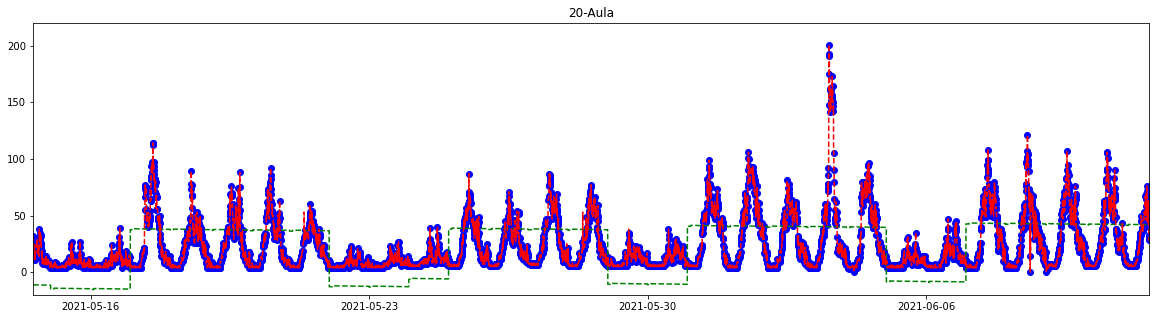

In [25]:
times = list(range(first_time_stamp, last_time_stamp + 300000, 300000))

estimate = pd.DataFrame()
estimate["time_bucket"] = times
estimate["building"] = a_building

estimate_extra_attribs = crowd_attributes.transform(estimate)
estimate_prepared = full_pipeline.transform(estimate_extra_attribs)

lin_preds = lin_reg.predict(estimate_prepared)
tree_preds = tree_reg.predict(estimate_prepared)

plt.figure(figsize=(20,5))
plt.title(a_building)
plt.axis([first_time_stamp, last_time_stamp, -20, 220])
plt.xticks(ticks=ticks, labels=labels)
plt.plot(a_building_data["time_bucket"], a_building_data["clientCount"], 'bo', times, lin_preds, 'g--', times, tree_preds, 'r--')
plt.show()

## See what happens when we try to predict the future

In [26]:
extra_days = 28
latest_time_stamp = last_time_stamp + extra_days*86400000 + 300000
times = list(range(first_time_stamp, latest_time_stamp, 300000))

estimate = pd.DataFrame()
estimate["time_bucket"] = times
estimate["building"] = a_building

estimate_extra_attribs = crowd_attributes.transform(estimate)
estimate_prepared = full_pipeline.transform(estimate_extra_attribs)

lin_preds = lin_reg.predict(estimate_prepared)
tree_preds = tree_reg.predict(estimate_prepared)

In [27]:
# start from first Sunday and mark each week
xticks = []
xlabels = []
for eptime in range(first_sunday, latest_time_stamp, week_in_milliseconds):
    xticks.append(eptime)
    xlabels.append(datetime.date.fromtimestamp(int(eptime/1000)))

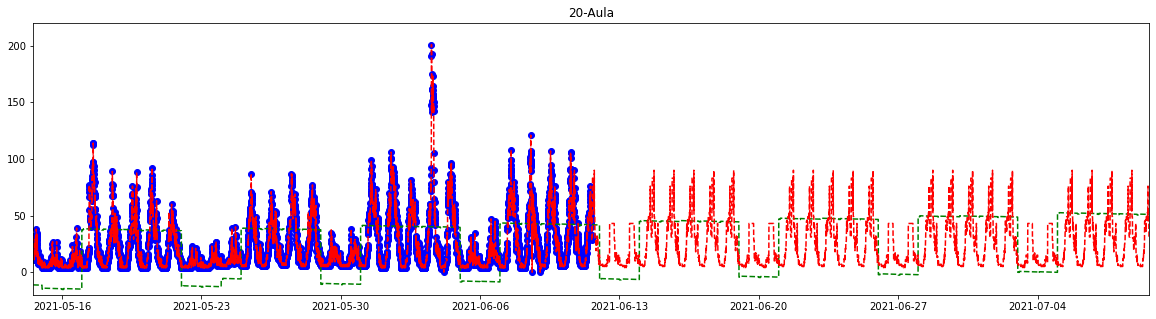

In [28]:
plt.figure(figsize=(20,5))
plt.title(a_building)
plt.axis([first_time_stamp, latest_time_stamp, -20, 220])
plt.xticks(ticks=xticks, labels=xlabels)
plt.plot(a_building_data["time_bucket"], a_building_data["clientCount"], 'bo', times, lin_preds, 'g--', times, tree_preds, 'r--')
plt.show()

## Make prettier graph for blog

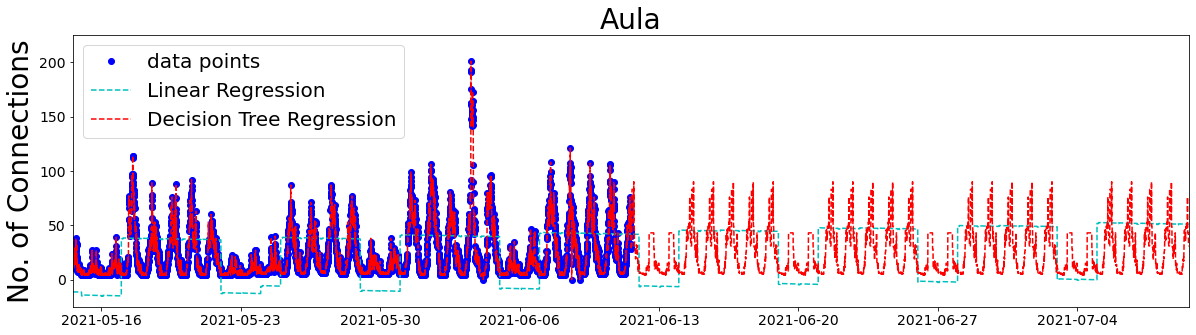

In [29]:
fontsize = 14
fslegend = 20

title = "Aula"

ymin = -25
ymax = 225
yticks = range(0, ymax+1, 50)

plt.figure(figsize=(20,5))
plt.title(title, fontsize=2*fontsize)
plt.axis([first_time_stamp, latest_time_stamp, ymin, ymax])
plt.xticks(ticks=xticks, labels=xlabels, fontsize=fontsize) 
plt.yticks(ticks=yticks, labels=yticks, fontsize=fontsize)
plt.ylabel("No. of Connections", fontsize=2*fontsize)
plt.plot(a_building_data["time_bucket"], a_building_data["clientCount"], 'bo', label="data points")
plt.plot(times, lin_preds, 'c--', label="Linear Regression")
plt.plot(times, tree_preds, 'r--', label="Decision Tree Regression")

plt.legend(loc='upper left', fontsize=fslegend)
plt.show()

# Evaluate on Test Set

In [30]:
X_test = strat_test_set.drop("clientCount", axis=1)
y_test = strat_test_set["clientCount"].copy()

test_extra_attribs = crowd_attributes.transform(X_test)
test_prepared = full_pipeline.transform(test_extra_attribs)

In [31]:
final_lin_predictions = lin_reg.predict(test_prepared)

final_lin_mse = mean_squared_error(y_test, final_lin_predictions)
final_lin_rmse = np.sqrt(final_lin_mse)

print('Final root mean squared error for linear regression is ', final_lin_rmse)

Final root mean squared error for linear regression is  99.75216004970864


In [32]:
final_tree_predictions = tree_reg.predict(test_prepared)

final_tree_mse = mean_squared_error(y_test, final_tree_predictions)
final_tree_rmse = np.sqrt(final_tree_mse)

print('Final root mean squared error for decission tree regressor is ', final_tree_rmse)

Final root mean squared error for decission tree regressor is  5.904503042481749


Save what we have so far:
```
from joblib import dump

dump(lin_reg, "lin_reg.joblib")
dump(tree_reg, "tree_reg.joblib")
```